# Baseline method

In [ ]:
# Code to preprocess and analyze gene expression data for cancer classification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load expression and metadata
tpm_norm = pd.read_csv("data/pnas_normal_tpm.txt", sep='\t')
tpm_norm['gene_id'] = tpm_norm.index
readcounts_norm = pd.read_csv("data/pnas_normal_readcounts.txt", sep='\t')
import pickle
readcounts_norm['gene_id'] = readcounts_norm.index

# Load expression and metadata
tpm = pd.read_csv("data/pnas_tpm_96_nodup.txt", sep='\t', header=None)
tpm.columns = ['gene_id'] + [f"C{i}" for i in range(1, tpm.shape[1])]
readcounts = pd.read_csv("data/pnas_readcounts_96_nodup.txt", sep='\t', header=None)
readcounts.columns = ['gene_id'] + [f"C{i}" for i in range(1, tpm.shape[1])]
patient_info = pd.read_csv("data/pnas_patient_info.csv")
sample_ids = [f"C{i}" for i in range(1, 97)]
patient_info["sampleID"] = sample_ids

# Filter for preselected genes
tpm = tpm.set_index('gene_id')
readcounts_filtered = readcounts.set_index('gene_id')
tpm_norm = tpm_norm.set_index('gene_id')
readcounts_norm = readcounts_norm.set_index('gene_id')

shared_genes = set(readcounts_norm.index) & set(readcounts_filtered.index) & set(tpm.index) & set(tpm_norm.index)

tpm_norm = tpm_norm[tpm_norm.index.isin(shared_genes)]
readcounts_norm = readcounts_norm[readcounts_norm.index.isin(shared_genes)]
tpm = tpm[tpm.index.isin(shared_genes)]
readcounts_filtered = readcounts_filtered[readcounts_filtered.index.isin(shared_genes)]

tpm_combined = pd.concat([tpm_norm, tpm], axis=1)

sample_order = tpm_combined.columns
labels = [0 for i in range(32)] + [1 for i in range(96)]

rc_df = tpm_combined.T
rc_df['label'] = labels

p_values = []
with open("data/genes_p_values.pkl", "rb") as f:
    p_values = pickle.load(f)

# Rank genes
ranked_genes = [gene for gene, _ in sorted(p_values, key=lambda x: x[1])]

df_tpm = tpm_combined.T
df_tpm = df_tpm[ranked_genes]
print(df_tpm.index)

df_tpm.index = df_tpm.index.astype(str)

# Create y: 1 if sample ID starts with “C” (cancer), else 0 (normal)
y = df_tpm.index.str.startswith("C").astype(int)

# X is the TPM matrix as a NumPy array
X = df_tpm.values

# # normalize the data with total read counts
# X = X / np.sum(X, axis=1, keepdims=True)

# Keep feature_names (gene names) for subsetting later
feature_names = df_tpm.columns.tolist()

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# count the number of samples in each class
print("Number of cancer samples:", np.sum(y == 1))
print("Number of normal samples:", np.sum(y == 0))

Index(['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10',
       ...
       'C87', 'C88', 'C89', 'C90', 'C91', 'C92', 'C93', 'C94', 'C95', 'C96'],
      dtype='object', length=128)
Shape of X: (128, 60675)
Shape of y: (128,)
Number of cancer samples: 96
Number of normal samples: 32


(161, 60675)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Shape of X: (161, 60675)
Shape of y: (161,)
LogisticRegression CV ROC AUC on training data: 1.0000 ± 0.0000
SVC CV ROC AUC on training data: 1.0000 ± 0.0000
RandomForestClassifier CV ROC AUC on training data: 0.9636 ± 0.0490
XGBClassifier CV ROC AUC on training data: 0.9723 ± 0.0554


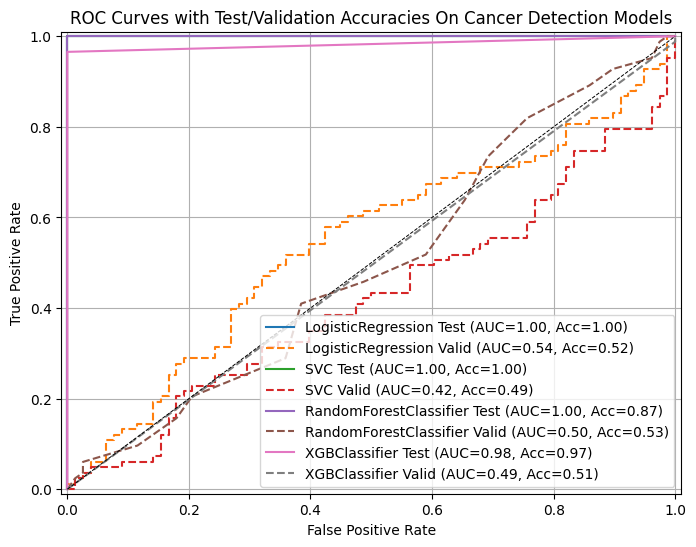

Number of cancer samples in validation set: 83
Number of normal samples in validation set: 78


In [ ]:
valid_cancer_patient = pd.read_excel("data/validation_bc_meta.xlsx")
valid_normal_patient = pd.read_excel("data/validation_normal_meta.xlsx")

cancer_patients = list(valid_cancer_patient['Mapping ID'])
normal_patients = list(valid_normal_patient['Mapping ID'])

# Load expression and metadata
tpm_valid = pd.read_csv("data/validation_exon_tpm", sep='\t')
readcounts_valid = pd.read_csv("data/validation_exon_readcounts", sep='\t')
readcounts_valid.columns = ['gene_id'] + [f"C{i}" for i in range(1, readcounts_valid.shape[1])]

tpm_df = tpm_valid.T
print(tpm_df.shape)

# Exclude the last row which is the label
X_valid = tpm_df.values
# X_valid = X_valid / np.sum(X_valid, axis=1, keepdims=True)
# Y is label column, where 1 is cancer and 0 is normal
tpm_df['label'] = tpm_df.index.map(
    lambda x: 1 if x in cancer_patients else (0 if x in normal_patients else np.nan)
)
y_valid = tpm_df['label'].values
print(y)
print("Shape of X:", X_valid.shape)
print("Shape of y:", y_valid.shape)

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

def plot_roc_curves_validation(models, X, y, X_valid, y_valid, test_size=0.3, random_state=42):
    """
    Train each model on a hold-out set with 5-fold CV on the training set,
    then plot ROC curves for both the internal test split and the external validation data.
    Also compute and display accuracy for test and validation sets in the legend.
    """
    # 1. Split data once so all models use identical train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    plt.figure(figsize=(8, 6))

    # 2. Fit each model with 5-fold CV on the training set, then compute ROC and accuracy
    for name, model in models.items():
        # 2a. 5-fold cross-validation on X_train/y_train
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        cv_scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc')
        print(f"{name} CV ROC AUC on training data: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

        # 2b. Fit on full training set
        model.fit(X_train, y_train)

        # 2c. Compute predictions and ROC on internal test set
        y_pred_test = model.predict(X_test)
        acc_test = accuracy_score(y_test, y_pred_test)

        if hasattr(model, "predict_proba"):
            y_scores_test = model.predict_proba(X_test)[:, 1]
        else:
            y_scores_test = model.decision_function(X_test)

        fpr_test, tpr_test, _ = roc_curve(y_test, y_scores_test)
        auc_test = roc_auc_score(y_test, y_scores_test)
        plt.plot(
            fpr_test,
            tpr_test,
            label=f"{name} Test (AUC={auc_test:.2f}, Acc={acc_test:.2f})"
        )

        # 2d. Compute predictions and ROC on external validation set
        y_pred_valid = model.predict(X_valid)
        acc_valid = accuracy_score(y_valid, y_pred_valid)

        if hasattr(model, "predict_proba"):
            y_scores_valid = model.predict_proba(X_valid)[:, 1]
        else:
            y_scores_valid = model.decision_function(X_valid)

        fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_scores_valid)
        auc_valid = roc_auc_score(y_valid, y_scores_valid)
        plt.plot(
            fpr_valid,
            tpr_valid,
            linestyle='--',
            label=f"{name} Valid (AUC={auc_valid:.2f}, Acc={acc_valid:.2f})"
        )

    # 3. Plot no-skill diagonal
    plt.plot([0, 1], [0, 1], 'k--', linewidth=0.7)

    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves with Test/Validation Accuracies On Cancer Detection Models')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
models = [
    LogisticRegression(max_iter=1000, random_state=42),
    SVC(probability=True, random_state=42),
    RandomForestClassifier(random_state=42),
    xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
]
plot_roc_curves_validation({model.__class__.__name__: model for model in models}, X, y, X_valid, y_valid)
# Print validation count
print("Number of cancer samples in validation set:", np.sum(y_valid == 1))
print("Number of normal samples in validation set:", np.sum(y_valid == 0))


Training X shape: (96, 60675)
Training y distribution: [68 28]
Validation X_valid shape: (83, 60675)
Validation y_valid distribution: [75  8]
LogisticRegression CV ROC AUC (train): 0.4994 ± 0.1137
SVM CV ROC AUC (train): 0.4139 ± 0.0740
RandomForest CV ROC AUC (train): 0.5458 ± 0.1354
XGBoost CV ROC AUC (train): 0.5489 ± 0.1277


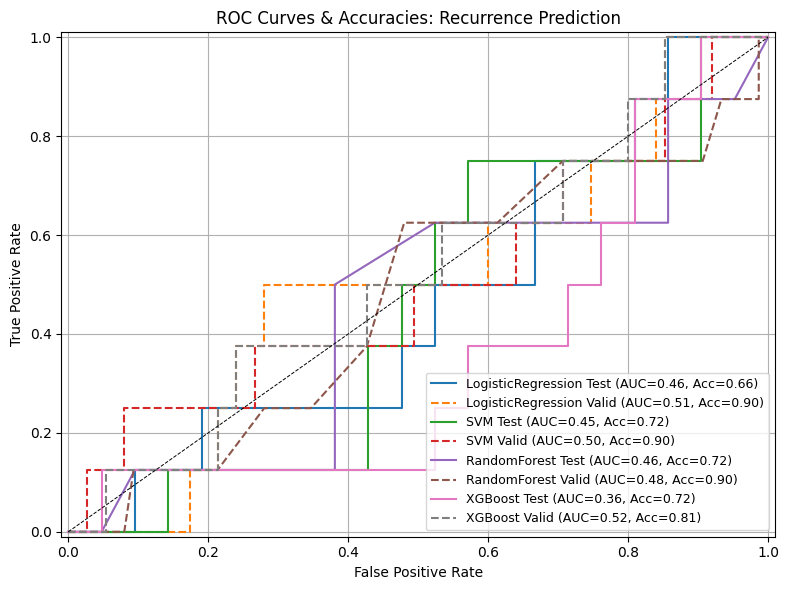

Number of recurrent samples in Training set: 28
Number of non-recurrent samples in Training set: 68
Number of recurrent samples in validation set: 8
Number of non-recurrent samples in validation set: 75


In [ ]:
# Code to train and validate models on recurrence prediction 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# load training data
tpm = pd.read_csv("data/pnas_tpm_96_nodup.txt", sep='\t', header=None)
tpm.columns = ['gene_id'] + [f"C{i}" for i in range(1, tpm.shape[1])]
tpm = tpm.set_index('gene_id')

patient_info = pd.read_csv("data/pnas_patient_info.csv")
sample_ids = [f"C{i}" for i in range(1, 97)]
patient_info["sampleID"] = sample_ids

X = tpm.T.values
labels = patient_info['recurStatus'].map({'N': 0, 'R': 1}).values

print("Training X shape:", X.shape)
print("Training y distribution:", np.bincount(labels))

# load validation data
valid_cancer_patient = pd.read_excel("data/validation_bc_meta.xlsx")
cancer_patients = list(valid_cancer_patient['Mapping ID'])

tpm_valid = pd.read_csv("data/validation_exon_tpm", sep='\t', header=0)


first_col_name = tpm_valid.columns[0]
tpm_valid.index = tpm_valid[first_col_name]
tpm_valid = tpm_valid.drop(columns=first_col_name)

tpm_valid = tpm_valid[cancer_patients]
tpm_valid_df = tpm_valid.T.sort_index()
label_map = valid_cancer_patient.set_index('Mapping ID')[
    'Recurrence Staus at the time of collection'
].map({'Nonrecurrent': 0, 'Recurrent': 1})
y_valid = tpm_valid_df.index.to_series().map(label_map).values

# (e) Build feature matrix for validation
X_valid = tpm_valid_df.values

print("Validation X_valid shape:", X_valid.shape)
print("Validation y_valid distribution:", np.bincount(y_valid))

# Training and validation with different models
def plot_roc_curves_validation(models, X, y, X_valid, y_valid,
                               test_size=0.3, random_state=42):
    """
    Train each model on a hold-out from (X, y) with 5-fold CV, then plot:
      • solid ROC curve = performance on internal test split
      • dashed ROC curve = performance on external validation (X_valid, y_valid)
    Also include test & validation accuracy in each legend entry.
    """
    # 1. Single stratified train/test split so all models see the same hold-out
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    plt.figure(figsize=(8, 6))

    for name, model in models.items():
        # 2a. 5-fold CV on the training set (report mean ± std AUC)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        cv_scores = cross_val_score(model, X_train, y_train,
                                     cv=skf, scoring='roc_auc')
        print(f"{name} CV ROC AUC (train): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

        # 2b. Fit on full training set
        model.fit(X_train, y_train)

        # 2c. Evaluate on internal test split
        y_pred_test = model.predict(X_test)
        acc_test = accuracy_score(y_test, y_pred_test)
        if hasattr(model, "predict_proba"):
            y_scores_test = model.predict_proba(X_test)[:, 1]
        else:
            y_scores_test = model.decision_function(X_test)

        fpr_test, tpr_test, _ = roc_curve(y_test, y_scores_test)
        auc_test = roc_auc_score(y_test, y_scores_test)
        plt.plot(
            fpr_test, tpr_test,
            label=f"{name} Test (AUC={auc_test:.2f}, Acc={acc_test:.2f})",
            linewidth=1.5
        )

        # 2d. Evaluate on external validation set
        y_pred_val = model.predict(X_valid)
        acc_val = accuracy_score(y_valid, y_pred_val)
        if hasattr(model, "predict_proba"):
            y_scores_val = model.predict_proba(X_valid)[:, 1]
        else:
            y_scores_val = model.decision_function(X_valid)

        fpr_val, tpr_val, _ = roc_curve(y_valid, y_scores_val)
        auc_val = roc_auc_score(y_valid, y_scores_val)
        plt.plot(
            fpr_val, tpr_val,
            linestyle='--',
            label=f"{name} Valid (AUC={auc_val:.2f}, Acc={acc_val:.2f})",
            linewidth=1.5
        )

    # 3. Plot the no-skill diagonal
    plt.plot([0, 1], [0, 1], 'k--', linewidth=0.7)

    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves & Accuracies: Recurrence Prediction')
    plt.legend(loc='lower right', fontsize=9)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

plot_roc_curves_validation(models, X, labels, X_valid, y_valid)

print("Number of recurrent samples in Training set:", np.sum(labels == 1))
print("Number of non-recurrent samples in Training set:", np.sum(labels == 0))
print("Number of recurrent samples in validation set:", np.sum(y_valid == 1))
print("Number of non-recurrent samples in validation set:", np.sum(y_valid == 0))

